In [37]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score

from control_systems.car_hillclimbing import HillClimbingCar
from pid_controller import PIDController
from anomaly_detection import CUSUMDetector

In [29]:
# CUSUM Tuning
cusum_thresholds = np.arange(2, 20, 0.5)
cusum_bs = np.arange(1, 13, 0.5)
best_f1 = float("-inf")
best_thres = 0
best_b = 0
for thres in cusum_thresholds:
    for cusum_b in cusum_bs:
        env = HillClimbingCar()

        run_tracker = env.run_control_system(   
                config={
                        "params": {
                            "m": 1200,       # Mass (kg)
                            "g": 9.81,       # Gravity (m/s^2)
                            "Cr": 0.01,      # Rolling resistance coefficient
                            "Cd": 0.3,       # Aerodynamic drag coefficient
                            "A": 2.2,        # Frontal area (m^2)
                            "rho": 1.225,    # Air density (kg/m^3)
                            "Fmax": 40000,    # Maximum engine force (N)
                        },
                        "init-state": np.array([0, 20]),  # [Position (m), Velocity (m/s)]
                        "dt": 0.1,
                        "time": 500,
                        "attack-start": 10,
                        "attack-end": 20,
                        "v-controller": PIDController(0.5, 0.5, 0.01),
                        "target-velocity": 20,
                        "process-noise-cov": np.diag([0.01, 0.1]),
                        "measurement-noise-cov": 0.2,
                        "anomaly-detector": CUSUMDetector(
                            thresholds=thres*np.array([0.16000361755278]),
                            b=np.array([0.18543593999687008]) + cusum_b*np.array([0.16000361755278])),
                    },
                show_plots=False
            )

        time = np.arange(0, 500, 0.1)
        attack_labels = [(x >= 10 and x <= 20) for x in time]
        attack_predictions = run_tracker.get_metrics(metric="attack_predictions")
        cm = confusion_matrix(attack_predictions, attack_predictions)
        prec = precision_score(attack_labels, attack_predictions)
        rec = recall_score(attack_labels, attack_predictions)
        acc = accuracy_score(attack_labels, attack_predictions)
        f1 = f1_score(attack_labels, attack_predictions)
        if f1 > best_f1:
            best_thres = thres
            best_b = cusum_b
            best_f1 = f1
            best_acc = acc
            best_rec = rec
            best_prec = prec
    print(f"-----------------\nParams: {best_thres, best_b}\nAccuracy: {best_acc}\nPrecision: {best_prec}\nRecall: {best_rec}")





/home/axel/miniconda3/envs/cats/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/axel/miniconda3/envs/cats/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/axel/miniconda3/envs/cats/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/axel/miniconda3/envs/cats/lib/python3.12/site-packages/sklearn/metrics/_classification.py:

-----------------
Params: (10.5, 7.5)
Accuracy: 0.999
Precision: 0.9897959183673469
Recall: 0.9603960396039604


In [59]:
# MSE
mmsce2 = []
for mag in range(1, 10):
    msce = []
    for _ in range(100):
        env = HillClimbingCar()
        run_tracker = env.run_control_system(   
            config={
                    "params": {
                        "m": 1200,       # Mass (kg)
                        "g": 9.81,       # Gravity (m/s^2)
                        "Cr": 0.01,      # Rolling resistance coefficient
                        "Cd": 0.3,       # Aerodynamic drag coefficient
                        "A": 2.2,        # Frontal area (m^2)
                        "rho": 1.225,    # Air density (kg/m^3)
                        "Fmax": 40000,    # Maximum engine force (N)
                    },
                    "init-state": np.array([0, 20]),  # [Position (m), Velocity (m/s)]
                    "dt": 0.1,
                    "time": 50,
                    "attack-start": 10,
                    "attack-end": 20,
                    "attack-magnitude": mag,
                    "v-controller": PIDController(0.5, 0.5, 0.01),
                    "target-velocity": 20,
                    "process-noise-cov": np.diag([0.01, 0.1]),
                    "measurement-noise-cov": 0.2,
                    "anomaly-detector": CUSUMDetector(
                        thresholds=10.5*np.array([0.16000361755278]),
                        b=np.array([0.18543593999687008]) + 7.5*np.array([0.16000361755278])),
                },
            show_plots=False
        )
        msce.append(np.mean(run_tracker.ms_control_error()))
    mmsce2.append(msce)


In [55]:
np.mean(msce), np.std(msce)

(6.945416828981613, 1.5582852595428953)

In [60]:
mmsce

[[1.2394993530961018,
  0.716866138378243,
  1.1581001396330879,
  1.1389033716844101,
  1.0945523267092965,
  1.7091209689987186,
  0.706034109934616,
  3.4828932197553297,
  0.7344541354703757,
  6.311446339175192,
  2.54567317878616,
  1.0535296626612074,
  1.8066019725535976,
  1.3755983297873395,
  1.1057262937590928,
  2.881783302155693,
  1.4976330250388534,
  0.7558491138881993,
  6.060332259576027,
  3.997509315922697,
  5.962353706069826,
  0.7004465416496831,
  0.8282993775018788,
  0.9483777670833048,
  1.1497341932706537,
  6.541297413143342,
  1.6139683762919166,
  5.137223028486922,
  2.218280187335575,
  2.409805344608582,
  3.938866757738063,
  6.369770293690431,
  1.1764569069653537,
  1.5695516908387863,
  1.438501917056007,
  7.624018800746597,
  14.960414406451992,
  1.8759742672216437,
  1.0286292609757757,
  2.4498358705841037,
  1.6742153115835692,
  3.2977135958103525,
  0.7715838604345964,
  1.590671280377795,
  3.4219876318813736,
  2.130609104344831,
  2.475

In [61]:
mmsce2

[[1.5251730983538587,
  2.1582316307355347,
  5.007142021239392,
  3.6561127155290154,
  2.9172005080130834,
  0.8416749831022722,
  1.9383284038341022,
  6.42452664311261,
  1.223095026554377,
  3.1573774291053285,
  2.341583516456729,
  1.657607064800578,
  2.1488891994528045,
  7.218700789020254,
  0.8782201954205016,
  1.3205303742761794,
  0.6992833752095161,
  1.9745663972816805,
  1.4835476709766857,
  0.9132654789292409,
  2.618703745312464,
  10.894040518286682,
  0.5299272252342319,
  1.6613053160726925,
  6.760011163264392,
  2.4490572980596834,
  0.6675312552638144,
  6.3960449922808005,
  0.9079793649425546,
  1.0675875281791793,
  1.4202443638319577,
  5.54011070800346,
  1.2827251306533975,
  4.480590951983375,
  17.269447112547283,
  11.235723799333984,
  1.8590750002474126,
  17.17600049209218,
  1.09416955712739,
  29.744775263561344,
  1.2016916867263923,
  8.015605455655335,
  4.235536469712787,
  0.8669386727329991,
  3.254980349305943,
  2.908568947025157,
  7.768

In [62]:
stats_base = [(np.mean(x), np.std(x)) for x in mmsce]
stats_ekf = [(np.mean(x), np.std(x)) for x in mmsce2]

In [63]:
stats_base

[(2.832507781423014, 2.731966852696139),
 (2.906980539729489, 2.3189911477739122),
 (3.974419222679005, 2.8821740646782383),
 (5.537558540264455, 2.6694691515266897),
 (6.988408049771854, 2.927412225644281),
 (9.073915296944083, 1.6407056926518482),
 (12.315243616441679, 2.469814534505944),
 (15.5058404754815, 2.0476267257742724),
 (20.36054567598587, 2.653298301283018)]

In [64]:
stats_ekf

[(4.291068675995974, 4.583600381541723),
 (5.493661806515961, 7.155542485222117),
 (4.293363980709232, 5.160414171290278),
 (4.44336095821563, 4.470654243522835),
 (5.201131238377831, 5.4657732726985655),
 (5.792390113324972, 7.833562170562348),
 (5.529581769538132, 3.9235456914677393),
 (6.270337314794597, 3.901243670583415),
 (7.22152837068931, 4.075659918571724)]

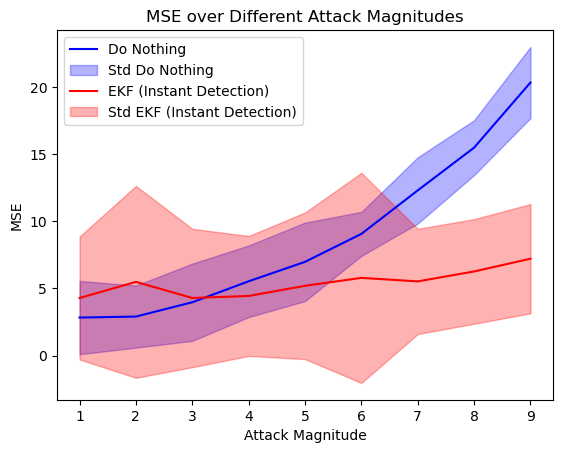

In [68]:
plt.plot(range(1, 10), [x[0] for x in stats_base], color="blue", label="Do Nothing")
plt.fill_between(range(1, 10), [-x[1]+x[0] for x in stats_base], [x[1] + x[0] for x in stats_base], color="blue", alpha=0.3, label="Std Do Nothing")
plt.plot(range(1, 10), [x[0] for x in stats_ekf], color="red", label="EKF (Instant Detection)")
plt.fill_between(range(1, 10), [-x[1] + x[0] for x in stats_ekf], [x[1] + x[0] for x in stats_ekf], color="red", alpha=0.3, label="Std EKF (Instant Detection)")
plt.title("MSE over Different Attack Magnitudes")
plt.xlabel("Attack Magnitude")
plt.ylabel("MSE")
plt.legend()
plt.show()

### PID-Tuning CarHillclimber

In [79]:


def pid_loss_fn(theta):
    Kp, Ki, Kd = theta
    env = HillClimbingCar()
    init_speed = 30*np.random.rand()

    tracker = env.run_control_system(
        config={
            "params": {
                "m": 1200,       # Mass (kg)
                "g": 9.81,       # Gravity (m/s^2)
                "Cr": 0.01,      # Rolling resistance coefficient
                "Cd": 0.3,       # Aerodynamic drag coefficient
                "A": 2.2,        # Frontal area (m^2)
                "rho": 1.225,    # Air density (kg/m^3)
                "Fmax": 40000,    # Maximum engine force (N)
            },
            "init-state": np.array([0, init_speed]),  # [Position (m), Velocity (m/s)]
            "dt": 0.1,
            "time": 50,
            "attack-start": -10,
            "attack-end": -20,
            "attack-magnitude": 0.0,
            "v-controller": PIDController(Kp, Ki, Kd),
            "target-velocity": 20,
            "process-noise-cov": np.diag([0.01, 0.1]),
            "measurement-noise-cov": 0.2,
            "anomaly-detector": CUSUMDetector(
                thresholds=10.5*np.array([0.16000361755278]),
                b=np.array([0.18543593999687008]) + 7.5*np.array([0.16000361755278])),
        },
        show_plots=False
    )

    loss = 0.1*tracker.ms_control_error().sum() / 50
    return loss

def compute_gradient(theta, delta):

    loss = pid_loss_fn(theta + delta*np.array([1,0,0]))
    dKp = (loss - pid_loss_fn(theta-delta*np.array([1,0,0]))) / (2*delta)
    dKi = (pid_loss_fn(theta + delta*np.array([0,1,0])) - pid_loss_fn(theta-delta*np.array([0,1,0]))) / (2*delta)
    dKd = (pid_loss_fn(theta + delta*np.array([0,0,1])) - pid_loss_fn(theta-delta*np.array([0,0,1]))) / (2*delta)

    return np.array([dKp, dKi, dKd]), loss


Loss at Step 0: 3.0037719533577474
Loss at Step 10: 2.927474337379327
Loss at Step 20: 2.9633476495605144
Loss at Step 30: 7.155367970599867
Loss at Step 40: 1.7771367539715197
Loss at Step 50: 2.3698208923820676
Loss at Step 60: 2.938858163643798
Loss at Step 70: 3.3950813005328566
Loss at Step 80: 6.849204407188466
Loss at Step 90: 4.208755873660497
Loss at Step 100: 7.243096497025303
Loss at Step 110: 3.7786366038266
Loss at Step 120: 2.3007914752876535
Loss at Step 130: 3.525039961031973
Loss at Step 140: 5.748587354761313
Loss at Step 150: 2.012506227575544
Loss at Step 160: 0.9018418275447868
Loss at Step 170: 2.224566112711632
Loss at Step 180: 4.2188847354054335
Loss at Step 190: 2.4068731557488063
Loss at Step 200: 4.654363358683967
Loss at Step 210: 3.714806677437826
Loss at Step 220: 3.0573926532193045
Loss at Step 230: 2.546007089875316
Loss at Step 240: 1.7589758372088602
Loss at Step 250: 14.891062618170876
Loss at Step 260: 1.9286967517379288
Loss at Step 270: 1.92640728

Text(0.5, 1.0, 'PID Controller Loss Function')

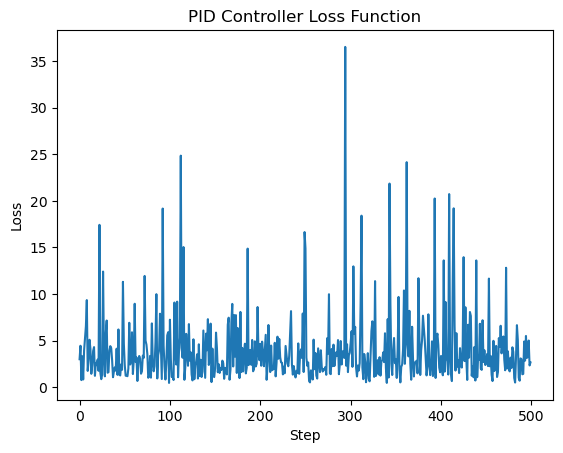

In [80]:
delta = 1e-5
theta0 = np.array([0.5, 0.5, 0.01])
lr = 1e-4
NBR_STEPS = 500


losses = []
theta = theta0
best_theta = theta0
best_loss = float("inf")
for step in range(NBR_STEPS):
    # Compute Gradient
    grad, loss = compute_gradient(theta, delta)
    grad = (1 / np.linalg.norm(grad, 2)) * grad
    
    # Gradient Descent
    theta = theta - lr*grad
    losses.append(loss)
    if loss < best_loss:
        best_theta = theta
    if step % 10 == 0:
        print(f"Loss at Step {step}: {loss}")

plt.plot(range(NBR_STEPS), losses)
plt.ylabel("Loss")
plt.xlabel("Step")
plt.title("PID Controller Loss Function")


In [81]:
best_theta

array([0.50320036, 0.50027134, 0.00711447])

### Data Analysis

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# file = f"./data/{sorted(os.listdir("./data"))[-1]}"
file = "./data/car_data_2025-02-1415:55:27.757194.csv"
# df = pd.read_csv(file)
# df.drop(labels=['Unnamed: 0'], axis=1, inplace=True)

In [340]:
df.head()

,time,pos,vel,est_pos,est_vel,det_est_pos,det_est_vel,measured_vel,ctl_signal,attack,attack_pred,residual,cusum_stat
0,0.00,0.000000,19.000000,0.000000,19.000000,0.189616,19.017772,18.923261,1.000000,False,False,-0.038370,0.000000
1,0.01,0.235989,19.036433,0.189616,19.017772,0.381552,19.505637,19.996296,0.014509,False,False,0.517361,0.000000
2,0.02,0.403361,18.988332,0.381552,19.505637,0.575679,19.290526,18.963226,1.000000,False,False,-0.257921,0.000000
3,0.03,0.622341,19.024872,0.575679,19.290526,0.767708,19.096440,18.790114,1.000000,False,False,-0.215497,0.000000
4,0.04,0.758755,19.112012,0.767708,19.096440,0.961174,19.768003,20.499031,-0.470750,False,False,0.746764,0.214639


In [342]:
df.iloc[1000:1020][['time', 'vel', 'est_vel', 'det_est_vel', 'measured_vel', 'attack', 'attack_pred', 'residual', 'cusum_stat']]

,time,vel,est_vel,det_est_vel,measured_vel,attack,attack_pred,residual,cusum_stat
1000,10.00,20.244692,19.986972,20.377906,20.754369,False,False,0.388215,0.763885
1001,10.01,20.223009,20.377906,22.669991,25.181400,True,False,2.407672,2.639432
1002,10.02,20.093897,22.669991,23.230472,24.010539,True,False,0.618197,2.725504
1003,10.03,19.986645,23.230472,24.037500,25.064312,True,False,0.835955,3.029335
1004,10.04,19.855277,24.037500,24.518133,25.218714,True,False,0.495107,2.992317
1005,10.05,19.765068,24.518133,25.130644,25.963264,True,False,0.619801,3.079993
1006,10.06,19.602329,25.130644,25.059534,25.208582,True,False,-0.067521,2.615388
1007,10.07,19.501416,25.059534,24.459383,24.079272,True,False,-0.598439,2.681702
1008,10.08,19.434534,24.459383,24.983044,25.726781,True,False,0.524637,2.674214
1009,10.09,19.335150,24.983044,24.152006,23.540945,True,False,-0.830708,2.972797


Precision: [nan]
Recall: [0.]


/tmp/ipykernel_97515/268889157.py:8: RuntimeWarning: invalid value encountered in divide
  print(f"Precision: {TP / (TP+FP)}")


Text(50.722222222222214, 0.5, 'Actual')

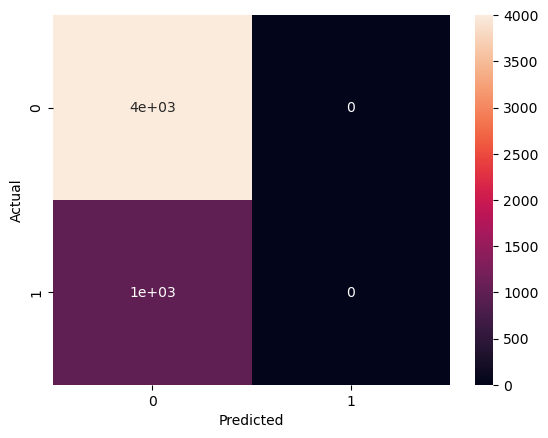

In [279]:
FP = df[(df.attack == False) & (df.attack_pred == True)][['attack']].count().values
TP = df[(df.attack == True) & (df.attack_pred == True)][['attack']].count().values
FN = df[(df.attack == True) & (df.attack_pred == False)][['attack']].count().values
TN = df[(df.attack == False) & (df.attack_pred == False)][['attack']].count().values

from sklearn.metrics import confusion_matrix
from seaborn import heatmap
print(f"Precision: {TP / (TP+FP)}")
print(f"Recall: {TP / (TP+FN)}")
cm = confusion_matrix(df.attack, df.attack_pred)
heatmap(data=cm, annot=True)
plt.xlabel("Predicted") 
plt.ylabel("Actual")

<Axes: xlabel='time', ylabel='attack_pred'>

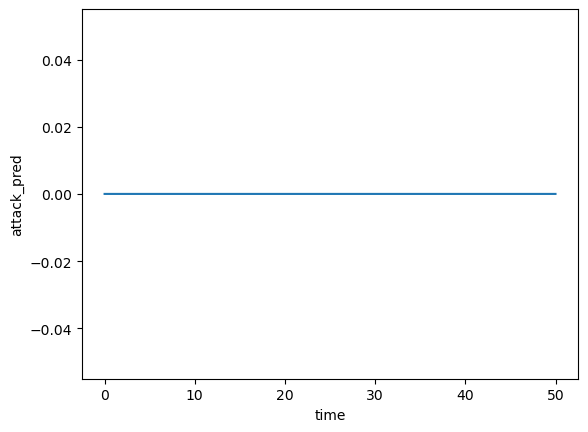

In [280]:
sns.lineplot(data=df, x='time', y='attack_pred')

<Axes: xlabel='time', ylabel='measured_vel'>

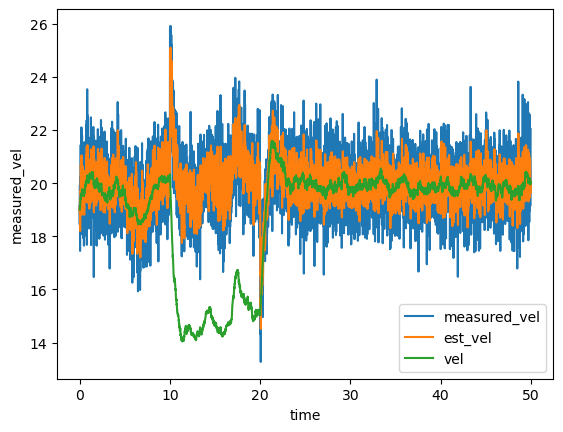

In [281]:
sns.lineplot(data=df, x='time', y='measured_vel', label="measured_vel")
sns.lineplot(data=df, x='time', y='est_vel', label="est_vel")
sns.lineplot(data=df, x='time', y='vel', label="vel")

### CUSUM Tuning

In [254]:
%reload_ext autoreload
%autoreload 2
from control_systems.car_hillclimbing import HillClimbingCar
from pid_controller import PIDController
from anomaly_detection import CUSUMDetector
import numpy as np
from sklearn.metrics import f1_score
import pandas as pd

attack_magnitudes = [3, 5]
taus = np.arange(4, 6, 0.2)
best_f1 = float('-inf')
best_b, best_tau = -1, -1

for tau in taus:
    bs = np.arange(0.4, 0.6, 0.02)
    for b in bs:
        dfs = []
        for attack_mag in attack_magnitudes:
            env = HillClimbingCar()
            logger = env.run_control_system(config=
                {
                    "params": {
                        "m": 1200,       # Mass (kg)
                        "g": 9.81,       # Gravity (m/s^2)
                        "Cr": 0.01,      # Rolling resistance coefficient
                        "Cd": 0.3,       # Aerodynamic drag coefficient
                        "A": 2.2,        # Frontal area (m^2)
                        "rho": 1.225,    # Air density (kg/m^3)
                        "Fmax": 40000,    # Maximum engine force (N)
                    },
                    "init-state": np.array([0, 19]),  # [Position (m), Velocity (m/s)]
                    "dt": 0.01,
                    "time": 50,
                    "attack-start": 10,
                    "attack-end": 20,
                    "attack-magnitude": attack_mag,
                    "v-controller": PIDController(0.1, 0.5, 0.0), # PIDController(0.50320036, 0.50027134, 0.00711447), 
                    "target-velocity": 20,
                    "process-noise-cov": np.diag([0.001, 0.001]),
                    "measurement-noise-cov": 0.1,
                    "anomaly-detector": CUSUMDetector(
                        thresholds=np.array([tau]),
                        b=np.array([b])),
                },
                show_plots=False)
            
            df = pd.DataFrame(logger.data)
            dfs.append(df)
        
        df = pd.concat(dfs)
        f1 = f1_score(df.attack, df.attack_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_b = b
            best_tau = tau


In [255]:
best_f1

0.3345332775219757

In [256]:
best_b


0.5400000000000001

In [257]:
best_tau

5.400000000000001

### Performance Evaluation

In [369]:
%reload_ext autoreload
%autoreload 2
NBR_ITERATIONS = 50
dfs = []
env = HillClimbingCar()
for i in range(NBR_ITERATIONS):
    np.random.seed(1000-i)
    attack_magnitude = np.random.rand()*4 + 3
    attack_start_time = np.random.randint(40)
    attack_length = np.random.randint(40)
    attack_end_time = min(attack_start_time + attack_length, 50)

    logger = env.run_control_system(config=
                {
                    "params": {
                        "m": 1200,       # Mass (kg)
                        "g": 9.81,       # Gravity (m/s^2)
                        "Cr": 0.01,      # Rolling resistance coefficient
                        "Cd": 0.3,       # Aerodynamic drag coefficient
                        "A": 2.2,        # Frontal area (m^2)
                        "rho": 1.225,    # Air density (kg/m^3)
                        "Fmax": 40000,    # Maximum engine force (N)
                    },
                    "init-state": np.array([0, 19]),  # [Position (m), Velocity (m/s)]
                    "dt": 0.01,
                    "time": 50,
                    "attack-start": attack_start_time,
                    "attack-end": attack_end_time,
                    "attack-magnitude": attack_magnitude,
                    "v-controller": PIDController(0.1, 0.5, 0.0), # PIDController(0.50320036, 0.50027134, 0.00711447), 
                    "target-velocity": 20,
                    "process-noise-cov": np.diag([0.001, 0.001]),
                    "measurement-noise-cov": 0.1,
                    "anomaly-detector": CUSUMDetector(
                        thresholds=np.array([4.0]),
                        b=np.array([1.7])),
                },
                show_plots=False)
    df = pd.DataFrame(logger.data)
    df['attack_magnitude'] = attack_magnitude
    dfs.append(df)
        
df = pd.concat(dfs)
df.to_csv('./data/recovery_data_cusum.csv')

CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Up

In [370]:
rec_df = pd.read_csv('./data/recovery_data.csv')
no_rec_df = pd.read_csv('./data/no_recovery_data.csv')
rec_df_c = pd.read_csv('./data/recovery_data_cusum.csv')

In [371]:
rec_df.head()

,Unnamed: 0,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal,attack,attack_pred,attack_magnitude
0,0,0.00,0.000000,19.000000,0.000000,19.000000,19.744324,0.026846,False,False,5.614358
1,1,0.01,0.180488,19.019068,0.185278,19.375568,19.011631,0.105057,False,False,5.614358
2,2,0.02,0.355500,19.070704,0.380330,19.209977,18.706036,0.142086,False,False,5.614358
3,3,0.03,0.567309,19.090368,0.574211,18.980564,17.994298,0.223289,False,False,5.614358
4,4,0.04,0.745375,19.156822,0.767414,18.523527,19.360015,0.089917,False,False,5.614358


In [372]:
rec_df['reference_vel'] = 20
rec_df['control_error'] = rec_df['reference_vel'] - rec_df['vel']
rec_MSE = rec_df['control_error'].map(lambda x: x*x).mean()

rec_df_c['reference_vel'] = 20
rec_df_c['control_error'] = rec_df_c['reference_vel'] - rec_df_c['vel']
rec_MSE_c = rec_df_c['control_error'].map(lambda x: x*x).mean()

no_rec_df['reference_vel'] = 20
no_rec_df['control_error'] = no_rec_df['reference_vel'] - no_rec_df['vel']
norec_MSE = no_rec_df['control_error'].map(lambda x: x*x).mean()

print(f"MSE with Recovery: {rec_MSE}")
print(f"MSE with Recovery (Standard CUSUM): {rec_MSE_c}")
print(f"MSE without Recovery: {norec_MSE}")

MSE with Recovery: 5.405004450321171
MSE with Recovery (Standard CUSUM): 4.565507802138088
MSE without Recovery: 8.250811353571818


Text(50.722222222222214, 0.5, 'Actual')

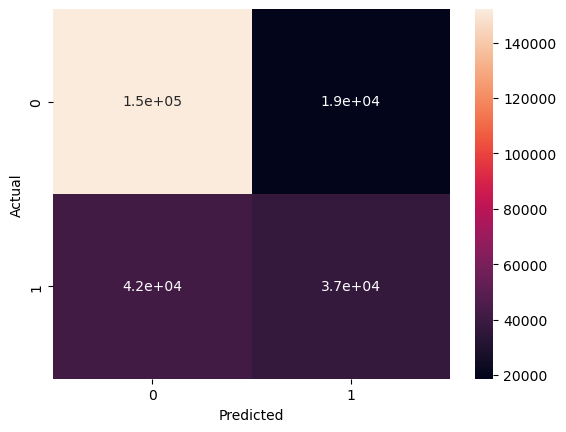

In [373]:
cm = confusion_matrix(rec_df.attack, rec_df.attack_pred)
heatmap(data=cm, annot=True)
plt.xlabel("Predicted") 
plt.ylabel("Actual")

In [374]:
from sklearn.metrics import recall_score, precision_score, accuracy_score
print(f"Accuracy: {accuracy_score(rec_df.attack, rec_df.attack_pred)}")
print(f"Precision: {precision_score(rec_df.attack, rec_df.attack_pred)}")
print(f"Recall: {recall_score(rec_df.attack, rec_df.attack_pred)}")

Accuracy: 0.757636
Precision: 0.6668454935622318
Recall: 0.47053034031116325


In [375]:
print(f"Accuracy: {accuracy_score(rec_df_c.attack, rec_df_c.attack_pred)}")
print(f"Precision: {precision_score(rec_df_c.attack, rec_df_c.attack_pred)}")
print(f"Recall: {recall_score(rec_df_c.attack, rec_df_c.attack_pred)}")

Accuracy: 0.684296
Precision: 0.5018214425825254
Recall: 0.5649140073942285


In [377]:
rec_df.describe()

,Unnamed: 0,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal,attack_magnitude,reference_vel,control_error
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.0,250000.000000
mean,2499.500000,24.995000,481.811914,19.021431,490.595468,19.361820,20.638563,0.036413,4.858452,20.0,0.978569
std,1443.378531,14.433785,275.821530,2.108892,283.359136,1.665963,1.899243,0.119311,1.220813,0.0,2.108892
min,0.000000,0.000000,0.000000,11.656283,0.000000,12.098382,12.510017,-0.791489,3.024078,20.0,-8.291415
25%,1249.750000,12.497500,245.319232,17.456850,247.386236,19.073343,19.424012,-0.028163,3.791052,20.0,-0.018910
50%,2499.500000,24.995000,484.238208,19.739308,489.837771,19.824821,20.289017,0.022440,4.650859,20.0,0.260692
75%,3749.250000,37.492500,715.847750,20.018910,728.270802,20.330979,21.442593,0.108442,5.990710,20.0,2.543150
max,4999.000000,49.990000,1226.470990,28.291415,1119.170757,25.493203,30.814600,0.749136,6.973266,20.0,8.343717


### Uncertainty Plot

In [ ]:
%reload_ext autoreload
%autoreload 2
from control_systems.car_hillclimbing import HillClimbingCar
from pid_controller import PIDController
from anomaly_detection import CUSUMDetector
from tqdm import tqdm
NBR_ITERATIONS = 50
dfs = []
env = HillClimbingCar()
attack_magnitude = 10
for i in tqdm(range(NBR_ITERATIONS), desc="Running Control System"):
    np.random.seed(4232+i)
    logger = env.run_control_system(config=
                {
                    "params": {
                        "m": 1200,       # Mass (kg)
                        "g": 9.81,       # Gravity (m/s^2)
                        "Cr": 0.01,      # Rolling resistance coefficient
                        "Cd": 0.3,       # Aerodynamic drag coefficient
                        "A": 2.2,        # Frontal area (m^2)
                        "rho": 1.225,    # Air density (kg/m^3)
                        "Fmax": 7000,    # Maximum engine force (N)
                    },
                    "init-state": np.array([0, 19.0]),  # [Position (m), Velocity (m/s)]
                    "dt": 0.01,
                    "time": 50,
                    "attack-start": 10,
                    "attack-end": 30,
                    "attack-magnitude": attack_magnitude,
                    "v-controller": PIDController(1.0, 1.0, 0.0), # PIDController(0.50320036, 0.50027134, 0.00711447), 
                    "target-velocity": 20,
                    "process-noise-cov": np.diag([0.001, 0.001]),
                    "measurement-noise-cov": 0.1,
                    "anomaly-detector": CUSUMDetector(
                        thresholds=np.array([3.4892164414032054]), # 4.0 Before
                        b=np.array([0.5321249776851772])), # 1.7 Before
                    "mission": [],
                },
                show_plots=False,
                save_data=False)
    df = pd.DataFrame(logger.data)
    df['attack_magnitude'] = attack_magnitude
    dfs.append(df)
        
df = pd.concat(dfs)
df.to_csv('./data/plot_recovery_attackmag10_cd.csv')

Running Control System: 100%|██████████| 50/50 [01:58<00:00,  2.37s/it]


In [252]:
df1 = pd.read_csv("./data/plot_no_recovery_slow_env.csv")
df1.drop('Unnamed: 0', axis=1, inplace=True)
df1['reference_vel'] = 20
df1['control_error'] = df1['reference_vel'] - df1['vel']
df2 = pd.read_csv("./data/plot_recovery_changereset_cusum.csv")
df2.drop('Unnamed: 0', axis=1, inplace=True)
df2['reference_vel'] = 20
df2['control_error'] = df2['reference_vel'] - df2['vel']
df3 = pd.read_csv("./data/plot_recovery_change_cusum.csv")
df3.drop('Unnamed: 0', axis=1, inplace=True)
df3['reference_vel'] = 20
df3['control_error'] = df3['reference_vel'] - df3['vel']

Text(0.5, 1.0, 'Velocity over time under presense of Attack')

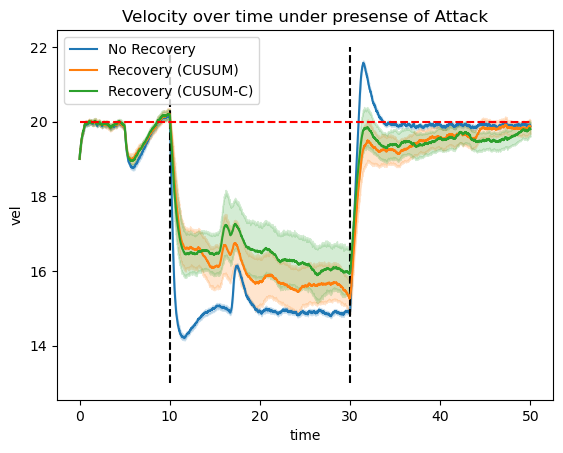

In [253]:
sns.lineplot(data=df1, x='time', y='vel', label="No Recovery")
plt.vlines(x=(10,30), ymin=(13,13), ymax=(22,22), color="black", linestyles="dashed")
sns.lineplot(data=df2, x='time', y='vel', label="Recovery (CUSUM)")
sns.lineplot(data=df3, x='time', y='vel', label="Recovery (CUSUM-C)")
plt.hlines(y=20, xmin=0, xmax=50, color="red", linestyles="dashed")
plt.title("Velocity over time under presense of Attack")

In [23]:
df = pd.read_csv("./data/plot_recovery_attackmag10_cd.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)
df['reference_vel'] = 20
df['control_error'] = df['reference_vel'] - df['vel']

Text(0.5, 1.0, 'Attack Prediction with CUSUM-CR')

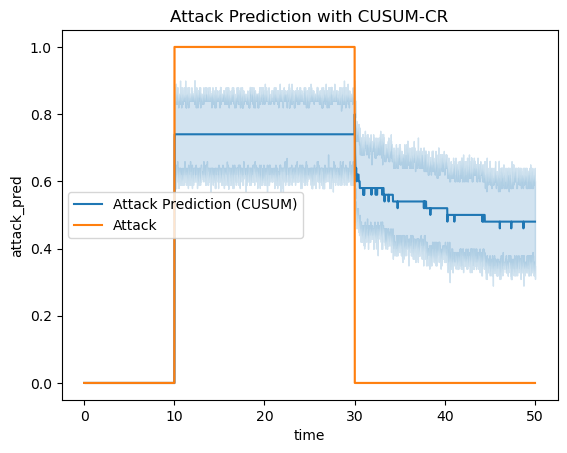

In [24]:
sns.lineplot(data=df, x='time', y='attack_pred', label="Attack Prediction (CUSUM)", n_boot=100)
sns.lineplot(data=df, x='time', y='attack', label="Attack", n_boot=1)
plt.title("Attack Prediction with CUSUM-CR")

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print(f"Precision: {precision_score(df.attack, df.attack_pred)}")
print(f"Recall: {recall_score(df.attack, df.attack_pred)}")
print(f"Accuracy: {accuracy_score(df.attack, df.attack_pred)}")

Precision: 0.5864550113443445
Recall: 0.7396198099049525
Accuracy: 0.687384


In [28]:
df[df.time > 9.9].head(20)

,time,pos,vel,est_pos,est_vel,det_est_pos,det_est_vel,measured_vel,reference_vel,ctl_signal,attack,attack_pred,residual,cusum_stat,attack_magnitude,control_error
991,9.91,196.098684,20.272563,196.523539,20.348317,196.725803,20.055512,19.748206,20,1.000000,False,False,-0.301141,0.000000,5,-0.272563
992,9.92,196.276522,20.260356,196.725803,20.055512,196.926478,20.091633,20.113238,20,1.000000,False,False,0.031975,0.000000,5,-0.260356
993,9.93,196.492979,20.221199,196.926478,20.091633,197.126779,19.950355,19.794540,20,1.000000,False,False,-0.143369,0.000000,5,-0.221199
994,9.94,196.668820,20.242667,197.126779,19.950355,197.323306,19.245566,18.526117,20,1.000000,False,False,-0.705907,0.000000,5,-0.242667
995,9.95,196.906474,20.269446,197.323306,19.245566,197.519166,20.024764,20.798145,20,0.924904,False,False,0.783150,0.000000,5,-0.269446
996,9.96,197.142500,20.308333,197.519166,20.024764,197.716848,19.414933,18.790474,20,1.000000,False,False,-0.612351,0.000000,5,-0.308333
997,9.97,197.343071,20.302900,197.716848,19.414933,197.915602,20.436430,21.539020,20,0.180735,False,False,1.068188,0.000000,5,-0.302900
998,9.98,197.491549,20.240056,197.915602,20.436430,198.121894,20.880878,21.390899,20,0.314946,False,False,0.459954,0.000000,5,-0.240056
999,9.99,197.684657,20.188695,198.121894,20.880878,198.326378,19.781609,18.667836,20,1.000000,False,False,-1.131641,0.000000,5,-0.188695
1000,10.00,197.925765,20.229694,198.326378,19.781609,198.528965,20.838854,22.037943,20,-0.339156,False,False,1.119380,0.000000,5,-0.229694


Text(0.5, 1.0, 'Attack Prediction with CUSUM-C')

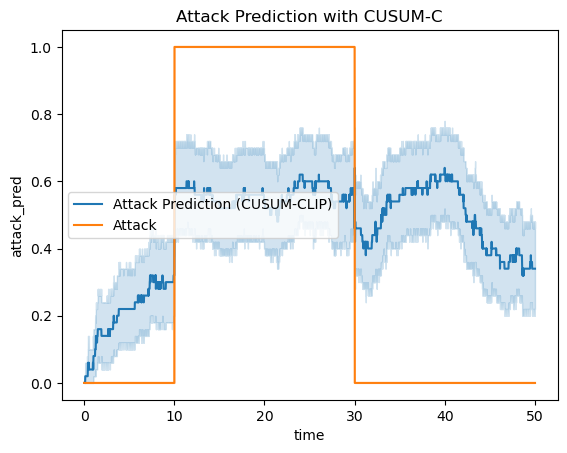

In [255]:
sns.lineplot(data=df3, x='time', y='attack_pred', label="Attack Prediction (CUSUM-CLIP)")
sns.lineplot(data=df3, x='time', y='attack', label="Attack")
plt.title("Attack Prediction with CUSUM-C")

In [254]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print(f"Precision: {precision_score(df3.attack, df3.attack_pred)}")
print(f"Recall: {recall_score(df3.attack, df3.attack_pred)}")
print(f"Accuracy: {accuracy_score(df3.attack, df3.attack_pred)}")

Precision: 0.4867432323003648
Recall: 0.5592896448224112
Accuracy: 0.58802


In [259]:
df2['residual'] = df2['measured_vel'] - df2['est_vel']
df3['residual'] = df3['measured_vel'] - df3['est_vel']
df2['abs_residual'] = df2.residual.map(np.abs)
df3['abs_residual'] = df3.residual.map(np.abs)
df3[(df3.time >= 30) & (df3.time < 30.1)][['time', 'measured_vel', 'est_vel', 'residual', 'abs_residual', 'cusum_stat', 'attack_pred']]

,time,measured_vel,est_vel,residual,abs_residual,cusum_stat,attack_pred
3000,30.00,14.908359,17.485126,-2.576767,2.576767,1.149096,False
3001,30.01,10.440119,16.282542,-5.842423,5.842423,4.344325,True
3002,30.02,13.994020,16.339001,-2.344981,2.344981,3.550041,True
3003,30.03,12.611174,16.395454,-3.784280,3.784280,3.216905,True
3004,30.04,11.178081,16.451901,-5.273820,5.273820,3.797942,True
...,...,...,...,...,...,...,...
248005,30.05,14.380543,15.045286,-0.664743,0.664743,1.862420,False
248006,30.06,14.160447,14.741200,-0.580753,0.580753,1.015502,False
248007,30.07,14.315184,14.479126,-0.163941,0.163941,0.000000,False
248008,30.08,14.559671,14.425475,0.134196,0.134196,0.000000,False


In [157]:
from scipy import stats
error_dist = stats.foldnorm(c=0.1928807536992423, loc=2.421456759549301e-07, scale=1.1469198514494972)
df3['cdf'] = df3['abs_residual'].map(error_dist.cdf)
df3.head()

,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal,attack,attack_pred,cusum_stat,attack_magnitude,reference_vel,control_error,residual,abs_residual,cdf
0,0.00,0.000000,19.000000,0.000000,19.000000,18.239700,1.000000,False,False,0.0,5,20,1.000000,-0.760300,0.760300,0.484773
1,0.01,0.213692,19.050143,0.195241,18.647885,19.863152,0.155820,False,False,0.0,5,20,0.949857,1.215267,1.215267,0.701751
2,0.02,0.416472,19.043555,0.377923,19.259011,19.573629,0.449606,False,False,0.0,5,20,0.956445,0.314619,0.314619,0.212273
3,0.03,0.573409,19.080114,0.569569,19.428324,19.239873,0.790964,False,False,0.0,5,20,0.919886,-0.188452,0.188452,0.128130
4,0.04,0.732937,19.101509,0.764614,19.356037,19.998308,0.032545,False,False,0.0,5,20,0.898491,0.642271,0.642271,0.417472


In [162]:
df3[df3.attack_pred][['attack','cdf', 'measured_vel', "est_vel"]]

,attack,cdf,measured_vel,est_vel
19,False,0.756555,17.832159,19.194851
35,False,0.988044,22.356436,19.421665
67,False,0.970916,22.005951,19.457354
90,False,0.871281,21.274751,19.500140
109,False,0.982819,22.331147,19.548704
...,...,...,...,...
249995,False,1.000000,28.253542,12.537818
249996,False,1.000000,27.652765,12.536368
249997,False,1.000000,27.783510,12.534893
249998,False,1.000000,28.321595,12.533318


In [113]:
df2.iloc[71000:71030]

,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal,attack,attack_pred,cusum_stat,attack_magnitude,reference_vel,control_error
71000,10.00,196.954738,19.999943,198.339058,19.851950,21.137858,0.541348,False,False,0.927145,5,20,0.000057
71001,10.01,197.179150,19.997889,198.533801,20.485191,25.203251,-1.000000,True,False,4.217535,5,20,0.002111
71002,10.02,197.370118,19.824761,198.724304,22.789577,26.012802,-1.000000,True,False,6.013089,5,20,0.175239
71003,10.03,197.592829,19.712120,198.941174,24.346389,23.984040,-1.000000,True,False,4.947767,5,20,0.287880
71004,10.04,197.780599,19.574937,199.185530,24.110227,22.961417,-1.000000,True,False,4.668906,5,20,0.425063
71005,10.05,197.947715,19.461050,199.430269,23.480832,25.465484,-1.000000,True,False,5.225888,5,20,0.538950
71006,10.06,198.084622,19.365975,199.657937,24.418286,24.379588,-1.000000,True,False,3.836916,5,20,0.634025
71007,10.07,198.217170,19.286952,199.901867,24.343953,24.234880,-1.000000,True,False,2.518318,5,20,0.713048
71008,10.08,198.414738,19.179784,200.145303,24.234435,21.985773,-0.648839,True,False,3.339311,5,20,0.820216
71009,10.09,198.583565,18.976977,200.395253,23.065319,21.831258,-0.512637,True,False,3.145701,5,20,1.023023


<Axes: xlabel='time', ylabel='est_error'>

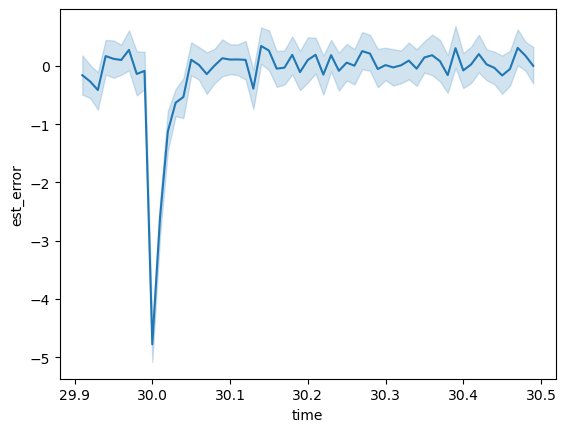

In [68]:
df1['est_error'] = df1['measured_vel'] - df1['est_vel']
sns.lineplot(data=df1[(df1.time > 29.9) & (df1.time < 30.5)], x='time', y='est_error')

### CUSUM Analysis

#### Estimate Residual Distribution (Attack Free)

In [31]:
%reload_ext autoreload
%autoreload 2
from control_systems.car_hillclimbing import HillClimbingCar
from pid_controller import PIDController
from anomaly_detection import CUSUMDetector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

NBR_ITERATIONS = 50
dfs = []
env = HillClimbingCar()
for i in range(NBR_ITERATIONS):
    np.random.seed(4232+i)
    logger = env.run_control_system(config=
                {
                    "params": {
                        "m": 1200,       # Mass (kg)
                        "g": 9.81,       # Gravity (m/s^2)
                        "Cr": 0.01,      # Rolling resistance coefficient
                        "Cd": 0.3,       # Aerodynamic drag coefficient
                        "A": 2.2,        # Frontal area (m^2)
                        "rho": 1.225,    # Air density (kg/m^3)
                        "Fmax": 7000,    # Maximum engine force (N)
                    },
                    "init-state": np.array([0.0, 19.0]),  # [Position (m), Velocity (m/s)]
                    "dt": 0.01,
                    "time": 50,
                    "attack-start": -10,
                    "attack-end": -30,
                    "attack-magnitude": 5,
                    "v-controller": PIDController(1.0, 1.0, 0.0), # PIDController(0.50320036, 0.50027134, 0.00711447), 
                    "target-velocity": 20,
                    "process-noise-cov": np.diag([0.001, 0.001]),
                    "measurement-noise-cov": 0.1,
                    "anomaly-detector": CUSUMDetector(
                        thresholds=np.array([4.0]),
                        b=np.array([1.7])),
                    "mission": [],
                },
                show_plots=False,
                save_data=False)
    df = pd.DataFrame(logger.data)
    dfs.append(df)
        
df = pd.concat(dfs)
df.to_csv('./data/cusum_analysis.csv')

In [32]:
df = pd.read_csv('data/cusum_analysis.csv')
df.drop("Unnamed: 0", axis=1, inplace=True)
df.head()

,time,pos,vel,est_pos,est_vel,det_est_pos,det_est_vel,measured_vel,reference_vel,ctl_signal,attack,attack_pred,residual,cusum_stat
0,0.00,0.000000,19.000000,0.000000,19.000000,0.186199,18.676035,18.239700,20,1.000000,False,False,-0.380150,0.0
1,0.01,0.213692,19.050143,0.186199,18.676035,0.375160,19.276474,19.863152,20,0.155820,False,False,0.621732,0.0
2,0.02,0.416472,19.043555,0.375160,19.276474,0.568446,19.449033,19.573629,20,0.449606,False,False,0.166048,0.0
3,0.03,0.573409,19.080114,0.568446,19.449033,0.762576,19.388346,19.239873,20,0.790964,False,False,-0.083876,0.0
4,0.04,0.732937,19.101509,0.762576,19.388346,0.957517,19.692951,19.998308,20,0.032545,False,False,0.337303,0.0


<Axes: xlabel='residual', ylabel='Count'>

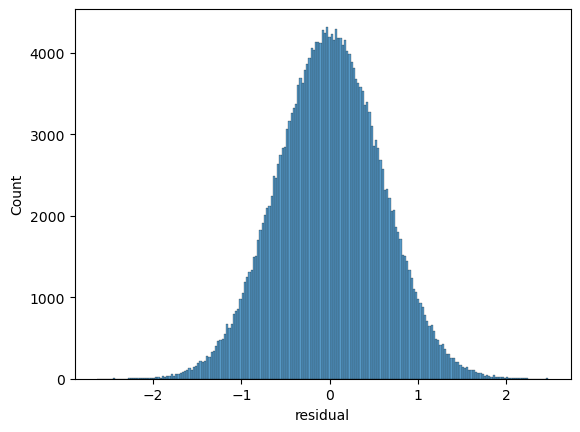

In [33]:
sns.histplot(data=df, x='residual')

<Axes: xlabel='abs_residual', ylabel='Count'>

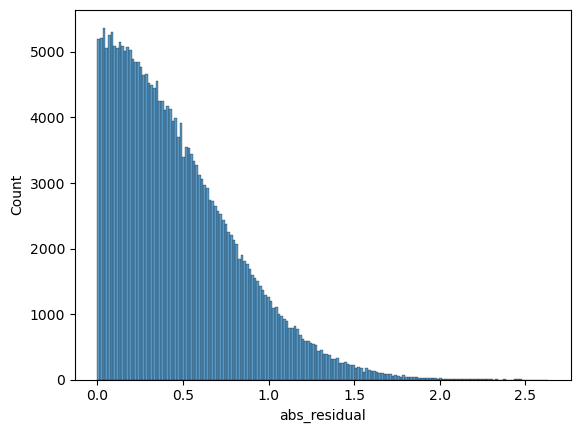

In [34]:
df['abs_residual'] = df.residual.map(np.abs)
sns.histplot(data=df, x='abs_residual')

<BarContainer object of 14 artists>

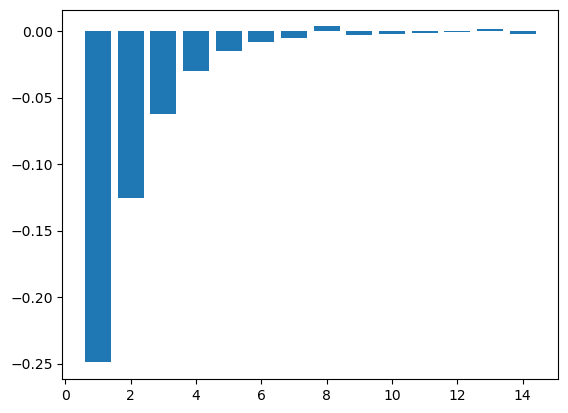

In [35]:
# Check for Autocorrelation
autocorrelations = [df.residual.autocorr(i) for i in range(1, 15)]
plt.bar(x=range(1,15), height=autocorrelations)

In [363]:
autocorrelations

[-0.24921220110011824,
 -0.12563486576035407,
 -0.06275625642253498,
 -0.030198412875352385,
 -0.015105003015377176,
 -0.008559395936085491,
 -0.0052446632332948245,
 0.0034143505986249613,
 -0.003180920508644148,
 -0.001914941787862397,
 -0.0013571701931957485,
 -0.001035473482670116,
 0.0015332178792521391,
 -0.002459669293904891]

In [37]:
# Fit a distribution to the residuals
from scipy import stats
bounds = [(-1, 1), (0, 5)]
res = stats.fit(stats.norm, df['residual'], bounds)

/home/axel/miniconda3/envs/cats/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2401: RuntimeWarning: overflow encountered in divide
  x = (x - loc) / scale


In [38]:
res

  params: FitParams(loc=0.0013588741354793044, scale=0.593512525217802)
 success: True
 message: 'Optimization terminated successfully.'

<Axes: title={'center': 'Fitted $\\tt norm$ PDF and Histogram'}, xlabel='x', ylabel='PDF'>

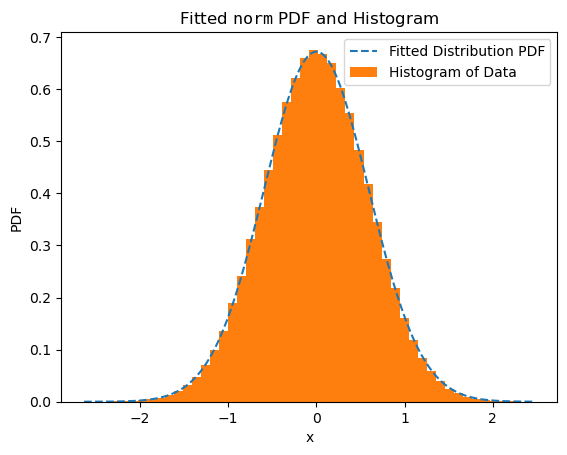

In [39]:
res.plot()

In [40]:
bounds = [(0, 10), (0, 10), (0, 10)]
fold_res = stats.fit(stats.foldnorm, df['abs_residual'], bounds)
fold_res

  params: FitParams(c=0.22812640523885896, loc=3.581552501685792e-06, scale=0.573362901174459)
 success: True
 message: 'Optimization terminated successfully.'

<Axes: title={'center': 'Fitted $\\tt foldnorm$ PDF and Histogram'}, xlabel='x', ylabel='PDF'>

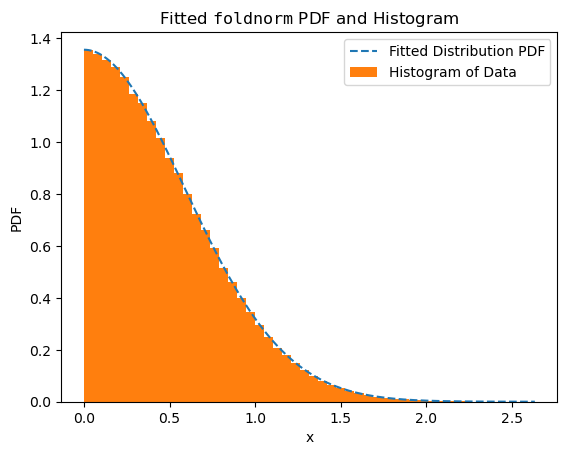

In [41]:
fold_res.plot()

In [42]:
x = stats.foldnorm(*fold_res.params)
print(f"Mean |measured vel. - estimated_vel| = {x.mean()}")
print(f"Var |measured vel. - estimated_vel| = {x.var()}")
print(f"Mean + 0.5Var: {x.mean()+0.5*x.var()}")


Mean |measured vel. - estimated_vel| = 0.46933357157689837
Var |measured vel. - estimated_vel| = 0.12558281221655765
Mean + 0.5Var: 0.5321249776851772


#### Estiamte Distribution of CUSUM Statistic (For Given $b = \mathbb{E}[e]+0.5\text{Var}[e]$)

In [415]:
ar_df = df.copy()
ar_df['experiment'] = ar_df.index // 5000

In [446]:
for _, group in ar_df.groupby('experiment'):
    group = group.drop(columns=['time', 'experiment'])
    print(group)
    break

             pos        vel      est_pos    est_vel  det_est_pos  det_est_vel  \
0       0.000000  19.000000     0.000000  19.000000     0.186199    18.676035   
1       0.213692  19.050143     0.186199  18.676035     0.375160    19.276474   
2       0.416472  19.043555     0.375160  19.276474     0.568446    19.449033   
3       0.573409  19.080114     0.568446  19.449033     0.762576    19.388346   
4       0.732937  19.101509     0.762576  19.388346     0.957517    19.692951   
...          ...        ...          ...        ...          ...          ...   
4995  996.070059  20.047417   999.212508  19.398416   999.407051    19.573291   
4996  996.291570  20.040808   999.407051  19.573291   999.603596    19.806176   
4997  996.450653  20.052865   999.603596  19.806176   999.803889    20.415801   
4998  996.652736  20.024736   999.803889  20.415801  1000.007228    20.156631   
4999  996.823575  19.994076  1000.007228  20.156631  1000.208161    19.969927   

      measured_vel  ctl_sig

In [432]:
ar_params = np.array(res.params)

In [434]:
res.params

const          0.000174
residual.L1   -0.417738
residual.L2   -0.372917
residual.L3   -0.299742
residual.L4   -0.253171
residual.L5   -0.222707
residual.L6   -0.146884
residual.L7   -0.097080
dtype: float64

In [433]:
ar_params

array([ 1.73913983e-04, -4.17737731e-01, -3.72916853e-01, -2.99742246e-01,
       -2.53170554e-01, -2.22706545e-01, -1.46883513e-01, -9.70800368e-02])

In [436]:
np.flip(ar_params)

array([-9.70800368e-02, -1.46883513e-01, -2.22706545e-01, -2.53170554e-01,
       -2.99742246e-01, -3.72916853e-01, -4.17737731e-01,  1.73913983e-04])

In [437]:
reduced_ar_df = ar_df.iloc[:5000]
reduced_ar_df['ar_prediction'] = reduced_ar_df.residual.rolling(window=7).apply(lambda x: (np.array(x) * ar_params[:7]).sum() + ar_params[-1])

/tmp/ipykernel_97515/249218399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_ar_df['ar_prediction'] = reduced_ar_df.residual.rolling(window=7).apply(lambda x: (np.array(x) * ar_params[:7]).sum() + ar_params[-1])


In [444]:
reduced_ar_df.iloc[10:20]

,time,pos,vel,est_pos,est_vel,det_est_pos,det_est_vel,measured_vel,ctl_signal,attack,attack_pred,residual,cusum_stat,experiment,ar_prediction,ar_residual
10,0.10,1.774433,19.231001,1.942238,19.401227,2.134730,19.018563,18.523654,1.000000,False,False,-0.409114,0.0,0,0.020798,0.429912
11,0.11,1.964099,19.242362,2.134730,19.018563,2.324212,18.878942,18.627019,1.000000,False,False,-0.152837,0.0,0,0.339887,0.492724
12,0.12,2.169179,19.312004,2.324212,18.878942,2.512867,18.898261,18.805270,1.000000,False,False,0.012724,0.0,0,0.144279,0.131555
13,0.13,2.410628,19.347905,2.512867,18.898261,2.703518,19.371231,19.816124,0.278801,False,False,0.511808,0.0,0,0.203659,-0.308149
14,0.14,2.654461,19.281049,2.703518,19.371231,2.897885,19.577833,19.748215,0.349227,False,False,0.221906,0.0,0,-0.134555,-0.356460
15,0.15,2.869106,19.321826,2.897885,19.577833,3.095242,20.015015,20.504958,-0.412565,False,False,0.489321,0.0,0,-0.123828,-0.613149
16,0.16,3.145171,19.314073,3.095242,20.015015,3.295046,19.923570,19.802745,0.291621,False,False,-0.106504,0.0,0,-0.340972,-0.234468
17,0.17,3.313583,19.285589,3.295046,19.923570,3.494212,19.912585,19.881227,0.214326,False,False,-0.014000,0.0,0,-0.457904,-0.443905
18,0.18,3.556520,19.312649,3.494212,19.912585,3.694908,20.341497,20.866027,-0.779134,False,False,0.485424,0.0,0,-0.581521,-1.066945
19,0.19,3.770550,19.283637,3.694908,20.341497,3.894373,19.142894,17.832159,1.000000,False,False,-1.274337,0.0,0,-0.257625,1.016712


In [439]:
reduced_ar_df['ar_residual'] = reduced_ar_df['ar_prediction'] - reduced_ar_df['residual']

/tmp/ipykernel_97515/2813770288.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_ar_df['ar_residual'] = reduced_ar_df['ar_prediction'] - reduced_ar_df['residual']


In [441]:
reduced_ar_df.iloc[10:15]

,time,pos,vel,est_pos,est_vel,det_est_pos,det_est_vel,measured_vel,ctl_signal,attack,attack_pred,residual,cusum_stat,experiment,ar_prediction,ar_residual
10,0.10,1.774433,19.231001,1.942238,19.401227,2.134730,19.018563,18.523654,1.000000,False,False,-0.409114,0.0,0,0.020798,0.429912
11,0.11,1.964099,19.242362,2.134730,19.018563,2.324212,18.878942,18.627019,1.000000,False,False,-0.152837,0.0,0,0.339887,0.492724
12,0.12,2.169179,19.312004,2.324212,18.878942,2.512867,18.898261,18.805270,1.000000,False,False,0.012724,0.0,0,0.144279,0.131555
13,0.13,2.410628,19.347905,2.512867,18.898261,2.703518,19.371231,19.816124,0.278801,False,False,0.511808,0.0,0,0.203659,-0.308149
14,0.14,2.654461,19.281049,2.703518,19.371231,2.897885,19.577833,19.748215,0.349227,False,False,0.221906,0.0,0,-0.134555,-0.356460


<BarContainer object of 14 artists>

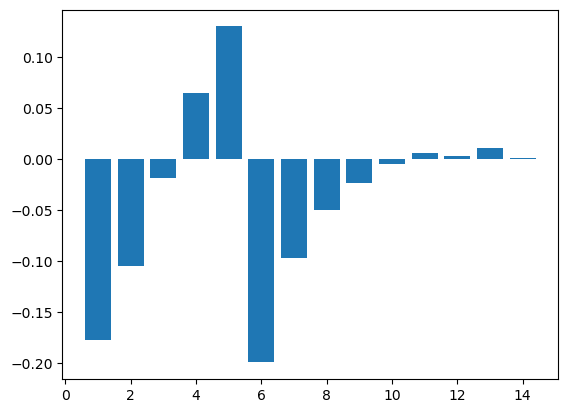

In [443]:
autocorrs = [reduced_ar_df.ar_residual.autocorr(i) for i in range(1,15)]
plt.bar(x=range(1,15), height=autocorrs)

In [43]:
# Get random sample of CUSUM Statistic
Ss = [0.0]
x = stats.norm(*res.params)
x_folded = stats.foldnorm(*fold_res.params)
b = x_folded.mean() + 0.5*x_folded.var()
last_n_samples = np.zeros(7)
autocorr = np.array(autocorrelations[0:5])
for t in range(1000000):
    # model_input = np.zeros(8)
    # model_input[1:] = last_n_samples
    # sample = x.rvs() + (model_input*params).sum()
    # last_n_samples = np.roll(last_n_samples, 1)
    # last_n_samples[0] = sample
    sample = x_folded.rvs()
    s = max(Ss[-1] + sample - b, 0)
    Ss.append(s)

<Axes: ylabel='Density'>

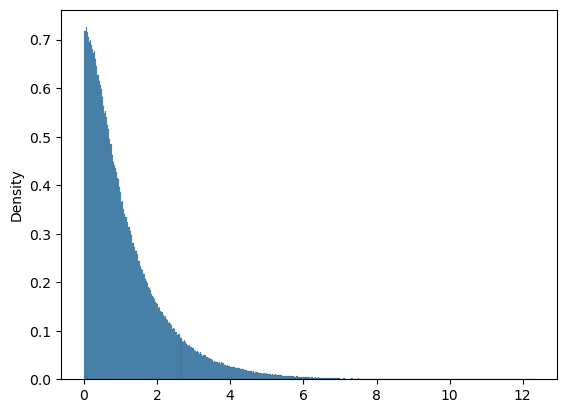

In [44]:
filtered_s = list(filter(lambda x: x != 0, Ss))
sns.histplot(x=filtered_s, stat='density')

<Axes: xlabel='cusum_stat', ylabel='Count'>

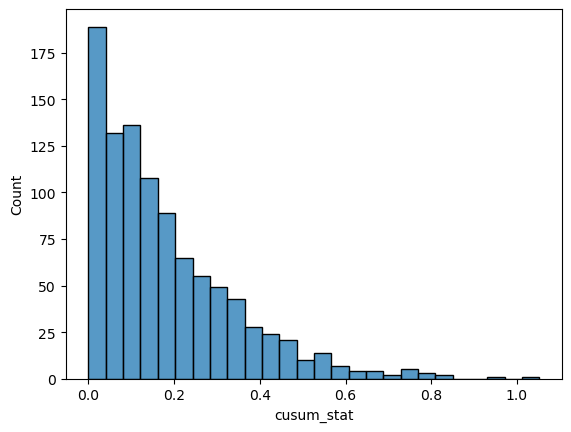

In [45]:
sns.histplot(data=df[df.cusum_stat != 0], x='cusum_stat')

In [23]:
# Folded Normal Fit
cusum_foldnorm_params = stats.fit(stats.foldnorm, data=filtered_s, bounds=bounds)
cusum_foldnorm_params

  params: FitParams(c=0.04322989716705017, loc=9.582552245035458e-07, scale=1.0886655902250597)
 success: True
 message: 'Optimization terminated successfully.'

<Axes: title={'center': 'Fitted $\\tt foldnorm$ PDF and Histogram'}, xlabel='x', ylabel='PDF'>

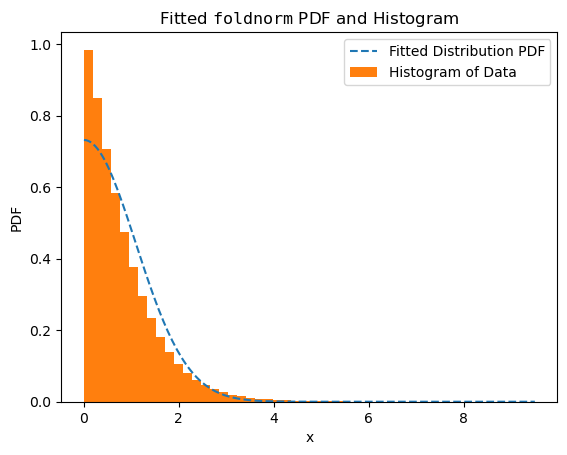

In [24]:
cusum_foldnorm_params.plot()

In [25]:
cusum_folded_dist = stats.foldnorm(*cusum_foldnorm_params.params)
cusum_folded_dist.ppf(0.995)

3.058771860548648

In [46]:
# Exponential Fit
bounds = [(0,10), (0,10)]
cusum_exp_params = stats.fit(dist=stats.expon, data=filtered_s, bounds=bounds)
cusum_exp_params

/home/axel/miniconda3/envs/cats/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2401: RuntimeWarning: overflow encountered in divide
  x = (x - loc) / scale


  params: FitParams(loc=2.2462424613678422e-06, scale=1.1647283123272265)
 success: True
 message: 'Optimization terminated successfully.'

<Axes: title={'center': 'Fitted $\\tt expon$ PDF and Histogram'}, xlabel='x', ylabel='PDF'>

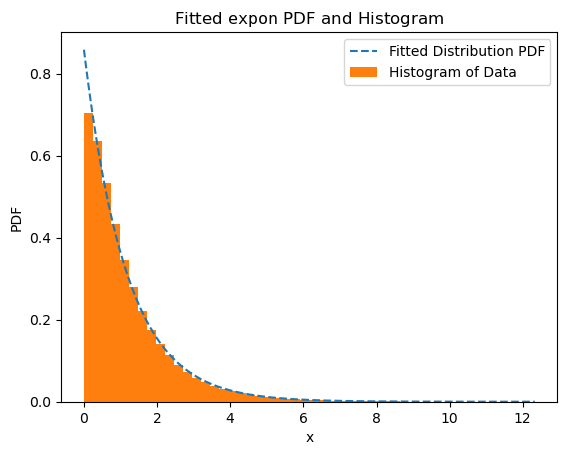

In [47]:
cusum_exp_params.plot()

In [48]:
len(filtered_s)

746995

In [49]:
len(Ss) - len(filtered_s)

253006

In [50]:
cusum_dist = stats.expon(*cusum_exp_params.params)
cusum_dist.ppf(0.95)

3.4892164414032054

**Comment:** Given this $b$, the threshold $\tau$ should be set to $\tau = 3.913736814314238$, this ensures a false positive rate of 5%

In [390]:
cusum_dist = stats.expon(*cusum_exp_params.params)
cusum_dist.ppf(0.99)

8.130833765996258

**Comment:** Given this $b$, the threshold $\tau$ should be set to $\tau = 6.016366525099714$, this ensures a false positive rate of 1%

In [391]:
cusum_dist = stats.expon(*cusum_exp_params.params)
cusum_dist.ppf(0.995)

9.354646048141163

##### Goodness of fit Test

In [534]:
res_exp = stats.goodness_of_fit(stats.expon, np.random.choice(filtered_s, 1000))
res_exp

/home/axel/miniconda3/envs/cats/lib/python3.12/site-packages/scipy/stats/_resampling.py:991: RuntimeWarning: invalid value encountered in scalar subtract
  cmps = null_distribution >= observed - gamma


GoodnessOfFitResult(fit_result=  params: FitParams(loc=0.0028114365111937545, scale=1.311443205371505)
 success: True
 message: 'The fit was performed successfully.', statistic=inf, pvalue=0.0001, null_distribution=array([inf, inf, inf, ..., inf, inf, inf]))

**Comment:** Goodness of fit test seems inconclusive but Exponential looks more reasonable if the histograms are considered.

#### Mean Time to Detection $\mathbb{E}[T]$

In [335]:
tau =  5.36377434494803 # 4.2443254268860375
detection_times = []
prev_s = 0
b = x.mean() + 0.5*x.var()
for j in range(10000):
    attack_time = np.random.randint(0, 90)
    prev_s = 0
    s = 0
    for i in range(100):
        sample = x.rvs()
        if i >= attack_time:
            sample += 3
        s = max(prev_s + sample - b, 0)
        prev_s = s
        if s > tau:
            detection_times.append(i-attack_time)
            break
        
    if len(detection_times) != j+1:
        detection_times.append(float('inf'))

In [336]:
# Compute Mean Detection Time
f_dt = list(filter(lambda x: x >= 0, detection_times))
fps = list(filter(lambda x: x < 0, detection_times))
print(f"Expected Detection Time = {sum(f_dt) / len(f_dt)}")
print(f"False Positive Rate = {round((len(fps) / len(detection_times)), 4)*100}%")

Expected Detection Time = 1.0075475495622421
False Positive Rate = 0.63%


In [572]:
df_noattack = pd.read_csv("./data/cusum_analysis.csv")
df_noattack['est_error'] = df_noattack['measured_vel'] - df_noattack['est_vel']

In [575]:
correlation_data = [df_noattack.est_error.autocorr(i) for i in range(1, 15)]

Text(0, 0.5, 'Auto-Correlation')

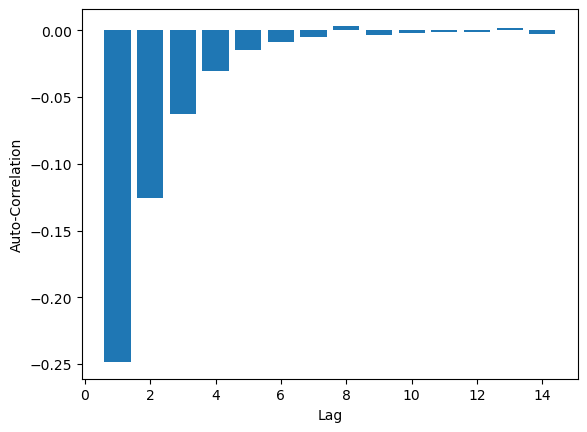

In [576]:
plt.bar(x=range(1,15), height=correlation_data)
plt.xlabel("Lag")
plt.ylabel("Auto-Correlation")

### Fit Autoregressive Model of Errors

In [392]:
df = pd.read_csv('data/cusum_analysis_new.csv')
df.drop("Unnamed: 0", axis=1, inplace=True)
df.head()

,time,pos,vel,est_pos,est_vel,det_est_pos,det_est_vel,measured_vel,ctl_signal,attack,attack_pred,residual,cusum_stat
0,0.00,0.000000,19.000000,0.000000,19.000000,0.186199,18.676035,18.239700,1.000000,False,False,-0.380150,0.0
1,0.01,0.213692,19.050143,0.186199,18.676035,0.375160,19.276474,19.863152,0.155820,False,False,0.621732,0.0
2,0.02,0.416472,19.043555,0.375160,19.276474,0.568446,19.449033,19.573629,0.449606,False,False,0.166048,0.0
3,0.03,0.573409,19.080114,0.568446,19.449033,0.762576,19.388346,19.239873,0.790964,False,False,-0.083876,0.0
4,0.04,0.732937,19.101509,0.762576,19.388346,0.957517,19.692951,19.998308,0.032545,False,False,0.337303,0.0


In [393]:
df['experiment'] = df.index.map(lambda x: x // 5000)
df.head()

,time,pos,vel,est_pos,est_vel,det_est_pos,det_est_vel,measured_vel,ctl_signal,attack,attack_pred,residual,cusum_stat,experiment
0,0.00,0.000000,19.000000,0.000000,19.000000,0.186199,18.676035,18.239700,1.000000,False,False,-0.380150,0.0,0
1,0.01,0.213692,19.050143,0.186199,18.676035,0.375160,19.276474,19.863152,0.155820,False,False,0.621732,0.0,0
2,0.02,0.416472,19.043555,0.375160,19.276474,0.568446,19.449033,19.573629,0.449606,False,False,0.166048,0.0,0
3,0.03,0.573409,19.080114,0.568446,19.449033,0.762576,19.388346,19.239873,0.790964,False,False,-0.083876,0.0,0
4,0.04,0.732937,19.101509,0.762576,19.388346,0.957517,19.692951,19.998308,0.032545,False,False,0.337303,0.0,0


In [199]:
ar_df = df.copy()
for lag in range(1, 9):
    ar_df[f'res_{lag}'] = ar_df.groupby('experiment')['residual'].shift(lag)

ar_df.head(10)

,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal,attack,attack_pred,residual,experiment,res_1,res_2,res_3,res_4,res_5,res_6,res_7,res_8
0,0.00,0.000000,19.000000,0.000000,19.000000,18.239700,1.000000,False,False,-0.760300,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.01,0.213692,19.050143,0.195241,18.647885,19.863152,0.155820,False,False,1.215267,0,-0.760300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.02,0.416472,19.043555,0.377923,19.259011,19.573629,0.449606,False,False,0.314619,0,1.215267,-0.760300,NaN,NaN,NaN,NaN,NaN,NaN
3,0.03,0.573409,19.080114,0.569569,19.428324,19.239873,0.790964,False,False,-0.188452,0,0.314619,1.215267,-0.760300,NaN,NaN,NaN,NaN,NaN
4,0.04,0.732937,19.101509,0.764614,19.356037,19.998308,0.032545,False,False,0.642271,0,-0.188452,0.314619,1.215267,-0.760300,NaN,NaN,NaN,NaN
5,0.05,0.958866,19.154088,0.956079,19.677014,20.757326,-0.734046,False,False,1.080312,0,0.642271,-0.188452,0.314619,1.215267,-0.760300,NaN,NaN,NaN
6,0.06,1.117979,19.040886,1.149128,20.194642,19.015696,1.000000,False,False,-1.178946,0,1.080312,0.642271,-0.188452,0.314619,1.215267,-0.760300,NaN,NaN
7,0.07,1.269392,19.095011,1.355287,19.633130,20.067997,-0.035554,False,False,0.434867,0,-1.178946,1.080312,0.642271,-0.188452,0.314619,1.215267,-0.760300,NaN
8,0.08,1.478033,19.097738,1.550166,19.848396,18.432246,1.000000,False,False,-1.416150,0,0.434867,-1.178946,1.080312,0.642271,-0.188452,0.314619,1.215267,-0.760300
9,0.09,1.635356,19.207211,1.753586,19.168301,19.547509,0.505137,False,False,0.379208,0,-1.416150,0.434867,-1.178946,1.080312,0.642271,-0.188452,0.314619,1.215267


In [207]:
data = df[['time', 'residual']].groupby('time').agg([np.mean, np.var])['residual']
data.head()

/tmp/ipykernel_97515/3180315279.py:1: FutureWarning: The provided callable <function mean at 0x79e17bf9c9a0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  data = df[['time', 'residual']].groupby('time').agg([np.mean, np.var])['residual']
/tmp/ipykernel_97515/3180315279.py:1: FutureWarning: The provided callable <function var at 0x79e17bf9cc20> is currently using SeriesGroupBy.var. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "var" instead.
  data = df[['time', 'residual']].groupby('time').agg([np.mean, np.var])['residual']


,mean,var
time,,
0.00,0.020610,0.873185
0.01,0.094548,1.164989
0.02,-0.106437,0.965171
0.03,0.161487,1.533264
0.04,0.189446,0.867643


In [394]:
data = df[df['experiment'] == 0].residual

In [395]:
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arma_mle import Arma

res = AutoReg(data, lags=list(range(1,8))).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:               residual   No. Observations:                 5000
Model:                     AutoReg(7)   Log Likelihood               -3888.536
Method:               Conditional MLE   S.D. of innovations              0.527
Date:                Mon, 17 Feb 2025   AIC                           7795.073
Time:                        12:45:46   BIC                           7853.715
Sample:                             7   HQIC                          7815.627
                                 5000                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0002      0.007      0.023      0.981      -0.014       0.015
residual.L1    -0.4177      0.014    -29.658      0.000      -0.445      -0.390
residual.L2    -0.3729      0.015    -24.645      0.000      -0.403      -0.343
residual.L3    -0.2997      0.016    -19.073      0.000      -0.331      -0.269
residual.L4    -0.2532      0.016    -15.942      0.000      -0.284      -0.222
residual.L5    -0.2227      0.016    -14.168      0.000      -0.254      -0.192
residual.L6    -0.1469      0.015     -9.705      0.000      -0.177      -0.117
residual.L7    -0.0971      0.014     -6.890      0.000      -0.125      -0.069
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9174           -0.8779j            1.2698           -0.1215
AR.2            0.9174           +0.8779j            1.2698            0.1215
AR.3            0.0320           -1.4205j            1.4209           -0.2464
AR.4            0.0320           +1.4205j            1.4209            0.2464
AR.5           -1.4535           -0.0000j            1.4535           -0.5000
AR.6           -0.9791           -1.1039j            1.4756           -0.3655
AR.7           -0.9791           +1.1039j            1.4756            0.3655
-----------------------------------------------------------------------------
"""

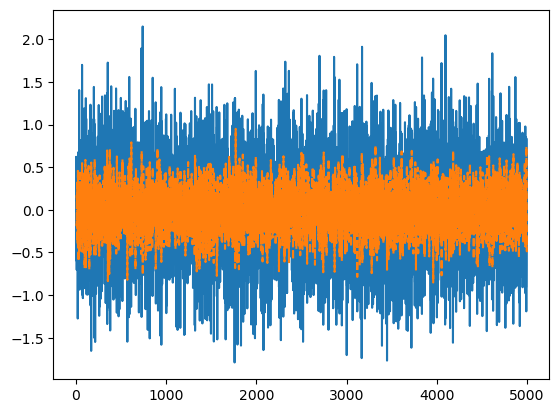

In [396]:
plt.plot(data, label="Actual")
plt.plot(res.fittedvalues, label="Fitted", linestyle='dashed')

In [397]:
predictions = res.predict(start=len(data), end=len(data)+10)

In [401]:
preds = res.predict(start=len(data)+10, end=len(data)+12)

In [402]:
preds

5010    0.000216
5011    0.008728
5012    0.009406
dtype: float64

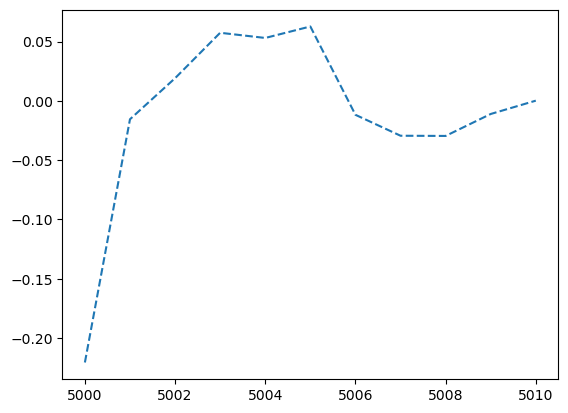

In [400]:

plt.plot(range(len(data), len(data)+11), predictions, label="Forecast", linestyle="dashed")

In [353]:
pd.DataFrame(res.resid).columns

RangeIndex(start=0, stop=1, step=1)

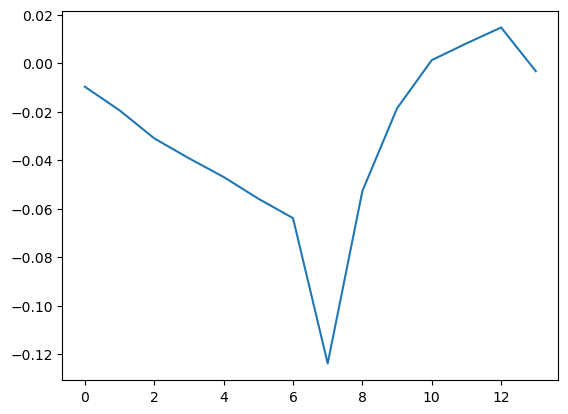

In [354]:
ac = [pd.DataFrame({"res": res.resid})['res'].autocorr(i) for i in range(1, 15)]
plt.plot(range(len(ac)), ac)

In [210]:
res_var = AutoReg(data['var'], lags=[1,2,3,4,5,6,7,8]).fit()
res_var.summary()

/home/axel/miniconda3/envs/cats/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                    var   No. Observations:                 5000
Model:                     AutoReg(8)   Log Likelihood                -569.296
Method:               Conditional MLE   S.D. of innovations              0.271
Date:                Thu, 13 Feb 2025   AIC                           1158.593
Time:                        12:27:01   BIC                           1223.749
Sample:                             8   HQIC                          1181.431
                                 5000                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2731      0.051     24.831      0.000       1.173       1.374
var.L1         0.0418      0.014      2.956      0.003       0.014       0.070
var.L2         0.0286      0.014      2.019      0.043       0.001       0.056
var.L3        -0.0014      0.014     -0.099      0.921      -0.029       0.026
var.L4         0.0103      0.014      0.725      0.469      -0.017       0.038
var.L5        -0.0054      0.014     -0.384      0.701      -0.033       0.022
var.L6         0.0002      0.014      0.011      0.991      -0.028       0.028
var.L7         0.0167      0.014      1.180      0.238      -0.011       0.044
var.L8        -0.0257      0.014     -1.816      0.069      -0.053       0.002
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.4059           -0.5816j            1.5215           -0.4376
AR.2           -1.4059           +0.5816j            1.5215            0.4376
AR.3           -0.5174           -1.4589j            1.5479           -0.3042
AR.4           -0.5174           +1.4589j            1.5479            0.3042
AR.5            0.7106           -1.4516j            1.6162           -0.1775
AR.6            0.7106           +1.4516j            1.6162            0.1775
AR.7            1.5378           -0.5683j            1.6395           -0.0563
AR.8            1.5378           +0.5683j            1.6395            0.0563
-----------------------------------------------------------------------------
"""

### Dataset for Autoencoder

In [447]:
def generate_random_mission(T: float, min_target: float, max_target: float, max_change_of_target: float, init_target: float, max_nbr_target_changes: int):
    """
    Generates a random mission

    Args:
        T (float): the total time for the mission
        min_target (float): the minimum allowed target value
        max_target (float): the maximum allowed target value
        max_change_of_target (float): the largest change allowed in the target
        init_target (float): the initial target
        max_nbr_target_changes (float): the maximum number of target changes

    Returns:
        mission (List[Tuple[float, float]]): a list of tuples defining the mission (time of change, target value)
    """
    # Random number of changes in the target value
    nbr_changes = np.random.randint(0, max_nbr_target_changes)
    last_time_of_change = 0.0
    current_target = init_target
    mission = []
    for _ in range(nbr_changes):
        # Get a random eligible time for the target change
        time_of_change = round(last_time_of_change + np.random.rand() * (T - last_time_of_change), 1)
        # Get a random change of the target value
        change_of_target = max_change_of_target*np.random.rand()
        current_target = current_target + change_of_target if np.random.rand() > 0.5 else current_target - change_of_target
        current_target = max(min_target, min(current_target, max_target))
        mission.append((time_of_change, current_target))
        last_time_of_change = time_of_change
    return mission

In [450]:
%reload_ext autoreload
%autoreload 2
from control_systems.car_hillclimbing import HillClimbingCar
from pid_controller import PIDController
from anomaly_detection import CUSUMDetector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

NBR_ITERATIONS = 50
dfs = []
env = HillClimbingCar()
for i in range(NBR_ITERATIONS):
    np.random.seed(4232+i)
    init_target = 7.0 + np.random.rand()*13
    mission = generate_random_mission(50.0, 7.0, 22.0, 5.0, init_target, 3)

    logger = env.run_control_system(config=
                {
                    "params": {
                        "m": 1200,       # Mass (kg)
                        "g": 9.81,       # Gravity (m/s^2)
                        "Cr": 0.01,      # Rolling resistance coefficient
                        "Cd": 0.3,       # Aerodynamic drag coefficient
                        "A": 2.2,        # Frontal area (m^2)
                        "rho": 1.225,    # Air density (kg/m^3)
                        "Fmax": 7000,    # Maximum engine force (N)
                    },
                    "init-state": np.array([0.0, init_target-1]),  # [Position (m), Velocity (m/s)]
                    "dt": 0.01,
                    "time": 50,
                    "attack-start": -10,
                    "attack-end": -30,
                    "attack-magnitude": 5,
                    "v-controller": PIDController(1.0, 1.0, 0.0), # PIDController(0.50320036, 0.50027134, 0.00711447), 
                    "target-velocity": init_target,
                    "process-noise-cov": np.diag([0.001, 0.001]),
                    "measurement-noise-cov": 0.1,
                    "anomaly-detector": CUSUMDetector(
                        thresholds=np.array([4.0]),
                        b=np.array([1.7])),
                    "mission": mission
                },
                show_plots=False,
                save_data=False)
    df = pd.DataFrame(logger.data)
    dfs.append(df)
        
df = pd.concat(dfs)
df.to_csv('./data/ae_data.csv')

In [455]:
df = pd.read_csv("./data/ae_data.csv")
df.drop(columns=['Unnamed: 0'], inplace=True)

In [456]:
df['experiment'] = df.index // 5000

,time,pos,vel,est_pos,est_vel,det_est_pos,det_est_vel,measured_vel,reference_vel,ctl_signal,attack,attack_pred,residual,cusum_stat
4999,49.99,673.362429,12.975281,678.120451,11.583514,678.240439,12.249829,12.945755,12.633308,-0.228483,False,False,0.733714,0.0
5000,0.00,0.000000,8.573215,0.000000,8.573215,0.085324,8.589547,8.491664,9.573215,1.000000,False,False,-0.040775,0.0
5001,0.01,0.075811,8.616929,0.085324,8.589547,0.168726,8.295779,7.887769,9.573215,1.000000,False,False,-0.322336,0.0
5002,0.02,0.153328,8.621772,0.168726,8.295779,0.251965,8.391847,8.373678,9.573215,1.000000,False,False,0.081799,0.0
5003,0.03,0.256925,8.648994,0.251965,8.391847,0.336840,8.580241,8.658696,9.573215,0.963330,False,False,0.183407,0.0
5004,0.04,0.341744,8.696346,0.336840,8.580241,0.426234,9.086004,9.590634,9.573215,0.031217,False,False,0.557671,0.0
5005,0.05,0.429322,8.706393,0.426234,9.086004,0.518651,9.314179,9.534682,9.573215,0.087555,False,False,0.250840,0.0
5006,0.06,0.543427,8.683518,0.518651,9.314179,0.609963,9.095829,8.780919,9.573215,0.849241,False,False,-0.251474,0.0
5007,0.07,0.581420,8.755237,0.609963,9.095829,0.701319,9.176538,9.210374,9.573215,0.423414,False,False,0.089002,0.0
5008,0.08,0.662695,8.779101,0.701319,9.176538,0.792406,9.115557,8.980144,9.573215,0.659574,False,False,-0.070618,0.0


In [457]:
df.head()

,time,pos,vel,est_pos,est_vel,det_est_pos,det_est_vel,measured_vel,reference_vel,ctl_signal,attack,attack_pred,residual,cusum_stat
0,0.00,0.000000,16.442814,0.000000,16.442814,0.159524,16.008867,15.461929,17.442814,1.000000,False,False,-0.490442,0.0
1,0.01,0.202908,16.501936,0.159524,16.008867,0.322726,16.688765,17.360445,17.442814,0.103002,False,False,0.704115,0.0
2,0.02,0.435625,16.518542,0.322726,16.688765,0.491437,17.099771,17.521555,17.442814,-0.058896,False,False,0.432567,0.0
3,0.03,0.588291,16.584260,0.491437,17.099771,0.663320,17.303445,17.517581,17.442814,-0.055669,False,False,0.214265,0.0
4,0.04,0.743183,16.617385,0.663320,17.303445,0.834291,16.865072,16.313931,17.442814,1.000000,False,False,-0.494729,0.0


### Create Attacked Dataset (No Recovery) For Tuning of AutoEncoder Threshold

In [458]:
%reload_ext autoreload
%autoreload 2
from control_systems.car_hillclimbing import HillClimbingCar
from pid_controller import PIDController
from anomaly_detection import CUSUMDetector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

NBR_ITERATIONS = 10
dfs = []
env = HillClimbingCar()
for i in range(NBR_ITERATIONS):
    np.random.seed(645+i)
    init_target = 7.0 + np.random.rand()*13
    mission = generate_random_mission(50.0, 7.0, 22.0, 5.0, init_target, 3)
    attack_start_time = np.random.randint(0, 48)
    attack_end_time = np.random.randint(attack_start_time+1, 49)
    attack_magnitide = np.random.rand()*8 + 3.0
    logger = env.run_control_system(config=
                {
                    "params": {
                        "m": 1200,       # Mass (kg)
                        "g": 9.81,       # Gravity (m/s^2)
                        "Cr": 0.01,      # Rolling resistance coefficient
                        "Cd": 0.3,       # Aerodynamic drag coefficient
                        "A": 2.2,        # Frontal area (m^2)
                        "rho": 1.225,    # Air density (kg/m^3)
                        "Fmax": 7000,    # Maximum engine force (N)
                    },
                    "init-state": np.array([0.0, init_target-1]),  # [Position (m), Velocity (m/s)]
                    "dt": 0.01,
                    "time": 50,
                    "attack-start": attack_start_time,
                    "attack-end": attack_end_time,
                    "attack-magnitude": attack_magnitude,
                    "v-controller": PIDController(1.0, 1.0, 0.0), # PIDController(0.50320036, 0.50027134, 0.00711447), 
                    "target-velocity": init_target,
                    "process-noise-cov": np.diag([0.001, 0.001]),
                    "measurement-noise-cov": 0.1,
                    "anomaly-detector": CUSUMDetector(
                        thresholds=np.array([4.0]),
                        b=np.array([1.7])),
                    "mission": mission
                },
                show_plots=False,
                save_data=False)
    df = pd.DataFrame(logger.data)
    dfs.append(df)
        
df = pd.concat(dfs)
df.to_csv('./data/ae_data_attacked.csv')